In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # better plotting and aesthetics
from pathlib import Path # just a utility for better cross-platform file-loading
from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC

In [5]:
data = pd.read_csv('Bank Customer Churn Prediction.csv')

In [6]:
data = data.drop('customer_id', axis = 1)

In [7]:
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Preprocessing

In [8]:
data['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
le = LabelEncoder()
data['country'] = le.fit_transform(data['country'])
data['gender'] = le.fit_transform(data['gender'])

In [10]:
data['country'].unique(), data['gender'].unique()

(array([0, 2, 1]), array([0, 1]))

In [11]:
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [12]:
data.isna().sum(), data.isnull().sum()

(credit_score        0
 country             0
 gender              0
 age                 0
 tenure              0
 balance             0
 products_number     0
 credit_card         0
 active_member       0
 estimated_salary    0
 churn               0
 dtype: int64,
 credit_score        0
 country             0
 gender              0
 age                 0
 tenure              0
 balance             0
 products_number     0
 credit_card         0
 active_member       0
 estimated_salary    0
 churn               0
 dtype: int64)

In [13]:
data.describe()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.746300,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Exploratory Data analysis

In [14]:
# Percentage of churn
data['churn'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: churn, dtype: float64

In [15]:
data[data['churn']==1].mean()

credit_score           645.351497
country                  0.805106
gender                   0.440844
age                     44.837997
tenure                   4.932744
balance              91108.539337
products_number          1.475209
credit_card              0.699067
active_member            0.360825
estimated_salary    101465.677531
churn                    1.000000
dtype: float64

In [16]:
# Here we can see those who holds credit card are likely to churn
pd.crosstab(data['churn'], data['credit_card'])

credit_card,0,1
churn,,
0,2332,5631
1,613,1424


In [17]:
# Females have higher churn rate than male
pd.crosstab(data['churn'], data['gender'])

gender,0,1
churn,,
0,3404,4559
1,1139,898


In [18]:
pd.crosstab(data['churn'], data['tenure'])

tenure,0,1,2,3,4,5,6,7,8,9,10
churn,,,,,,,,,,,
0,318,803,847,796,786,803,771,851,828,771,389
1,95,232,201,213,203,209,196,177,197,213,101


In [19]:
pd.crosstab(data['churn'], data['products_number'])

products_number,1,2,3,4
churn,,,,
0,3675,4242,46,0
1,1409,348,220,60


<Axes: xlabel='credit_card', ylabel='count'>

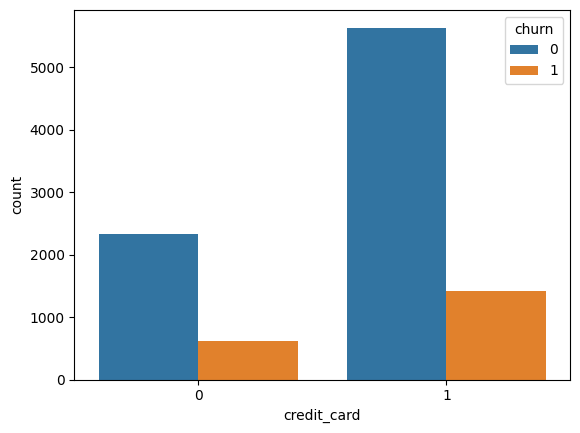

In [20]:
sns.countplot(x="credit_card", hue="churn", data=data)

<Axes: xlabel='gender', ylabel='count'>

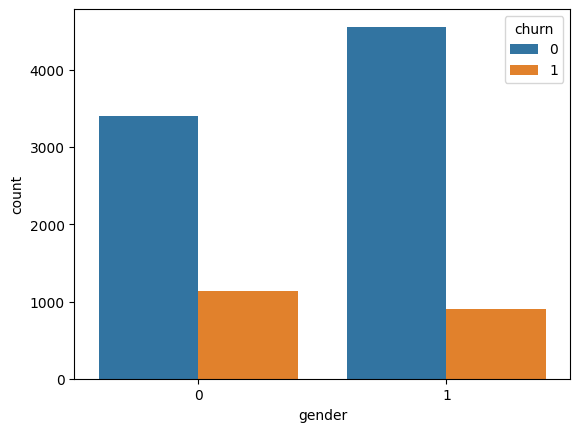

In [21]:
sns.countplot(x="gender", hue="churn", data=data)

### Modelling

#### Computing AUC scores of each feature

In [24]:
# Performing auc roc to determine which features are best suitable
# Creating a dataframe with just features
X = data.drop("churn", axis=1)

# A dataframe with just the target variable
y = data["churn"]
auc = []
for i in X.columns:
    auc.append(round(roc_auc_score(y, X[i]), 3))
# CONVERTING INTO DATAFRAMES
auc = pd.DataFrame(auc, columns=["AUC_Scores"])
columns = pd.DataFrame(X.columns, columns=["Feature_Names"])

final_auc_scores = pd.concat([columns, auc], axis=1)

# Sorting AUC values that are farthest from 0.5
difference = abs(0.5 - final_auc_scores["AUC_Scores"])
final_auc_scores["difference"] = difference
top10_auc = final_auc_scores.sort_values(by=["difference"],
                                         ascending=False)
top10_auc = top10_auc.drop(["difference"], axis=1)

In [25]:
top10_auc

,Feature_Names,AUC_Scores
3,age,0.732
8,active_member,0.403
6,products_number,0.421
5,balance,0.578
2,gender,0.434
1,country,0.535
0,credit_score,0.483
4,tenure,0.490
9,estimated_salary,0.509
7,credit_card,0.496


### KNN, ANN Implementation

In [10]:
# Importing libraries

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [26]:
def model() -> None:
    print("ANN Implementation... \n")
    # Load the dataset
    data = pd.read_csv("Bank Customer Churn Prediction.csv")

    # Checking the nulls
    # print("Null value check:\n", data.isnull().sum())

    # Dropping the unwanted columns from the data
    data = data.drop(columns="customer_id", axis=1)

    # Country have 3 string values and gender have 2 string values.
    # Hence, we convert the string values into numerical
    # values by using label encoder
    country_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()

    data["country"] = country_encoder.fit_transform(data["country"])
    data["gender"] = gender_encoder.fit_transform(data["gender"])

    # Creating a dataframe with just features
    X = data.drop("churn", axis=1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Defining the target variable
    y = data["churn"]

    # Printing the counts of each class of the target variable
    print("Checking the counts of each target class:\n",
          data.churn.value_counts())

    # CREATING K-FOLD
    folds = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    # Empty lists for storing the error rates of different models
    errorRate_Knn1 = []
    errorRate_Knn5 = []
    errorRate_Knn10 = []
    errorRate_ann1 = []
    errorRate_ann2 = []

    # Modelling
    for train_idx, test_idx in folds.split(X, y):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # ANN1 with hyperparameter tuned parameters
        
        ann1 = MLP(hidden_layer_sizes=(5, 10, 15, 20), activation="relu",solver="adam", random_state=0, max_iter=500, learning_rate='invscaling', learning_rate_init=0.005, shuffle=True).fit(X_train,y_train)
        ann_pred_1 = ann1.predict(X_test)
        errorRate_ann1.append(1 - accuracy_score(ann_pred_1, y_test))

        # ANN2
        ann2 = MLP(
            hidden_layer_sizes=(8, 16, 32, 48, 64), activation="relu",
            random_state=0, max_iter=500, solver="adam"
        ).fit(X_train, y_train)
        ann_pred_2 = ann2.predict(X_test)
        errorRate_ann2.append(1 - accuracy_score(ann_pred_2, y_test))

        # KNN model with k = 1
        knn1 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
        y_pred_knn1 = knn1.predict(X_test)
        errorRate_Knn1.append(1 - accuracy_score(y_pred_knn1, y_test))

        # KNN model with k = 5
        knn5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
        y_pred_knn5 = knn5.predict(X_test)
        errorRate_Knn5.append(1 - accuracy_score(y_pred_knn5, y_test))

        # KNN model with k = 10
        knn10 = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
        y_pred_knn10 = knn10.predict(X_test)
        errorRate_Knn10.append(1 - accuracy_score(y_pred_knn10, y_test))

    # Appending the mean error rate of each model in their respective list
    errorRate_Knn1.append(np.mean(errorRate_Knn1))
    errorRate_Knn5.append(np.mean(errorRate_Knn5))
    errorRate_Knn10.append(np.mean(errorRate_Knn10))
    errorRate_ann1.append(np.mean(errorRate_ann1))
    errorRate_ann2.append(np.mean(errorRate_ann2))

    # Dataframe for storing the error rates of
    # all the model's different folds and it's mean
    stratified_KFold_scores = pd.DataFrame(
        index=["knn1", "knn5", "knn10", "ann1", "ann2"],
        columns=["fold1", "fold2", "fold3", "fold4", "fold5", "mean"],
    )
    stratified_KFold_scores.index.name = "classifier"

    stratified_KFold_scores.loc[stratified_KFold_scores.index[0]] = \
        errorRate_Knn1
    stratified_KFold_scores.loc[stratified_KFold_scores.index[1]] = \
        errorRate_Knn5
    stratified_KFold_scores.loc[stratified_KFold_scores.index[2]] = \
        errorRate_Knn10
    stratified_KFold_scores.loc[stratified_KFold_scores.index[3]] = \
        errorRate_ann1
    stratified_KFold_scores.loc[stratified_KFold_scores.index[4]] = \
        errorRate_ann2
    print(stratified_KFold_scores.to_markdown(index=True))

In [23]:
model()

ANN Implementation... 

Checking the counts of each target class:
 0    7963
1    2037
Name: churn, dtype: int64
| classifier   |   fold1 |   fold2 |   fold3 |   fold4 |   fold5 |   mean |
|:-------------|--------:|--------:|--------:|--------:|--------:|-------:|
| knn1         |  0.215  |  0.221  |  0.213  |  0.2045 |  0.221  | 0.2149 |
| knn5         |  0.1855 |  0.187  |  0.185  |  0.178  |  0.1805 | 0.1832 |
| knn10        |  0.1875 |  0.1855 |  0.185  |  0.1775 |  0.187  | 0.1845 |
| ann1         |  0.145  |  0.148  |  0.1415 |  0.1435 |  0.1365 | 0.1429 |
| ann2         |  0.142  |  0.145  |  0.144  |  0.145  |  0.141  | 0.1434 |


#### Here we can see from the above table that the mean error is less for ANN1 model which uses tuned parameters.

### Hyper-parameter Tuning for ANN

In [5]:
data = pd.read_csv("Bank Customer Churn Prediction.csv")

# Checking the nulls
# print("Null value check:\n", data.isnull().sum())

# Dropping the unwanted columns from the data
data = data.drop(columns="customer_id", axis=1)

# Country have 3 string values and gender have 2 string values.
# Hence, we convert the string values into numerical
# values by using label encoder
country_encoder = LabelEncoder()
gender_encoder = LabelEncoder()

data["country"] = country_encoder.fit_transform(data["country"])
data["gender"] = gender_encoder.fit_transform(data["gender"])

# Creating a dataframe with just features
X = data.drop("churn", axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Defining the target variable
y = data["churn"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
cv = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
grid2 = {
    'hidden_layer_sizes' :[5,10,15,(5,5),(5,10),(5,10,15,20),(5,15,30,50)],
    'activation': ['tanh','relu'],
    'solver' : ['adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [0,0.0001,0.0005,0.001,0.005,0.01],
    'shuffle' : [True, False]
}
gridSearch1 = GridSearchCV(MLP(max_iter = 500), param_grid=grid2, cv = cv, scoring=['accuracy'], refit ='accuracy', verbose=2)
gridSearch1.fit(X_train,y_train)
print('Score: ', gridSearch1.best_score_)
print('Best Params: ', gridSearch1.best_params_)

Fitting 1 folds for each of 504 candidates, totalling 504 fits
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   3.3s


C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   4.2s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.0s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.5s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.3s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=constant, learning_rate_init=0.01, shuffle=True, solver=adam; total t

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   3.0s


C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   4.9s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   4.3s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.5s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.1s
[CV] END activation=tanh, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.01, shuffle=True, solver=adam; total t

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.2s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.7s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.4s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.4s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.01, shuffle=True, solver=adam; 

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.1s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.6s


C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   1.9s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   3.0s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.4s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.01, shuffle=True, solver=adam; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=invscaling, learning_rate_init=0.01, shuffle=False, solver=adam; total time=   1.2s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0, shuffle=True, solver=a

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.2s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.5s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.4s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.6s
[CV] END activation=tanh, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.01, shuffle=True, solver=adam; 

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.8s


C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.8s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.4s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   2.0s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.01, shuffle=True, solver=adam; total time=   2.0s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.01, shuffle=False, solver=adam; total time=   1.3s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0, shuffle=True, solver=adam; total

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   4.3s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   3.7s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.8s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.7s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   1.7s
[CV] END activation=tanh, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.01, shuffle=True,

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=   6.6s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   6.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   4.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   5.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   3.1s
[CV] END activation=tanh, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   6.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   4.6s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.3s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.6s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   4.1s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   3.4s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10), learning_rate=adaptive, learning_rate_ini

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=  41.9s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=  40.3s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=  18.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=  10.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=  10.4s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   6.7s
[CV] END activation=tanh, hidden_layer_sizes=(

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=  18.4s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   6.8s


C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=  21.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=  10.7s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   7.2s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   7.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   7.5s
[CV] END activation=tanh, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   8.1s
[CV] END activation=tanh, hidden_layer_sizes=(5

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=  50.0s
[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=  32.8s
[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=  19.5s
[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=  31.5s
[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   7.3s
[CV] END activation=tanh, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.005, shuffle=False, solver=adam; total time=  18.4s
[CV] END activation=tanh, hidden_la

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   4.8s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.4s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   5.7s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   5.3s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.5s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   0.9s
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=adaptive, learning_rate_init=0.01, shuffle=True, solver=adam; total t

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   4.3s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   8.6s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.0s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.5s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.0s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   1.8s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=constant, learning_rate_init=0.005, shuffle=False, solver=ada

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   6.4s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   3.1s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   3.2s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.7s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   3.2s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.9s
[CV] END activation=relu, hidden_layer_sizes=10, learning_rate=adaptive, learning_rate_init=0.005, shuffle=False, solver=ada

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=   5.5s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   3.8s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.8s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   2.7s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   5.4s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.5s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=ada

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   4.8s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.9s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   7.1s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.2s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.0s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   2.1s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, learning_rate_init=0.005, shuffle=Fal

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=  13.8s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   5.2s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   3.5s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   5.4s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   8.8s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   2.1s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=constant, learning_rate_init=0.0

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=   7.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   6.0s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   3.1s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   2.1s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   3.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   3.9s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, learning

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   8.4s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   5.0s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   2.9s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   4.0s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   3.4s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=adaptive, learning_rate_init=0.00

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=   8.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   2.6s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   6.0s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   3.2s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.005, shuffle=True, solver=adam; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_init=0.005, shuffle=False, solver=adam; total time=   2.6s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=constant, learning_rate_ini

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=  15.3s
[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=   6.8s
[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=  15.4s
[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=   7.9s
[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=   6.1s
[CV] END activation=relu, hidden_layer_sizes=(5, 10, 15, 20), learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=   6.4s
[CV] END activation=relu, hidden_

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=True, solver=adam; total time=  47.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0001, shuffle=False, solver=adam; total time=  46.6s
[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=True, solver=adam; total time=  28.5s
[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.0005, shuffle=False, solver=adam; total time=  13.0s
[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.001, shuffle=True, solver=adam; total time=  16.5s
[CV] END activation=relu, hidden_layer_sizes=(5, 15, 30, 50), learning_rate=invscaling, learning_rate_init=0.001, shuffle=False, solver=adam; total time=  15.8s
[CV] END activation=relu, hidden_

C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
84 fits failed out of a total of 504.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "C:\Users\mangu\AppData\Local\Programs\Python\Python310\lib\site-

Score:  0.871875
Best Params:  {'activation': 'relu', 'hidden_layer_sizes': (5, 10, 15, 20), 'learning_rate': 'invscaling', 'learning_rate_init': 0.005, 'shuffle': True, 'solver': 'adam'}
